In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

from CNOT import qoptimize, Hmat, initial
import jax.numpy as jnp
import jax.random as random
import jax

key = random.PRNGKey(42)

In [2]:
psi_i = jnp.array([0,0,0,1],dtype=jnp.complex128)
psi_f = 1/jnp.sqrt(2)*jnp.array([0, 1, 1, 0], dtype=jnp.complex128)
t1 = 1.
flat_p = jnp.concatenate([jnp.array([5]+[0 for _ in range(9)]),jnp.array([5]+[0 for _ in range(9)]),
                        jnp.array([5]+[0 for _ in range(9)]),jnp.array([24])])
loss_list, res_state = qoptimize(Hmat,psi_i,psi_f,t1,flat_p,num_step=100)

final loss =  1.5249486470145977e-05e-05


(100,)


Text(0.5, 1.0, '$\\Omega(t)$')

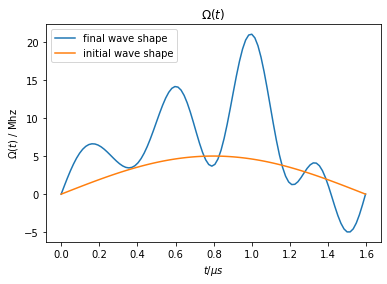

In [3]:
from CNOT import unpackp
N1 = 10
t0 = res_state[0]
w = jnp.pi/t0
t_list = jnp.linspace(0,t0,100)
u_omega, u_delta, V = unpackp(res_state[1])
u_o_init,u_d_init,V = unpackp(flat_p)
U = jnp.array([jnp.sin(w*(i+1)*t_list) for i in range(N1)])
print((u_omega@U).shape)
l1 = plt.plot(t_list,u_omega@U)
l2 =plt.plot(t_list,u_o_init@U)
plt.legend(labels=['final wave shape','initial wave shape'],loc='best')
plt.xlabel('$t/\mu s$')
plt.ylabel('$\Omega(t)$ / Mhz')
plt.title('$\Omega(t)$')

Text(0, 0.5, 'Log10 infidelity')

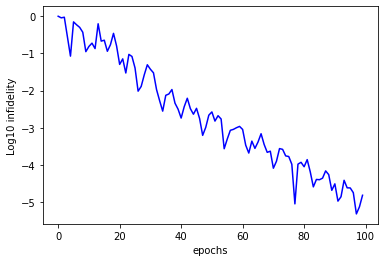

In [30]:
l3 = plt.plot(jnp.array([x for x in range(len(loss_list))]), jnp.log10(jnp.array(loss_list)),'b')
plt.xlabel('epochs')
plt.ylabel('Log10 infidelity')

Text(0.5, 1.0, '$\\Delta$(t)')

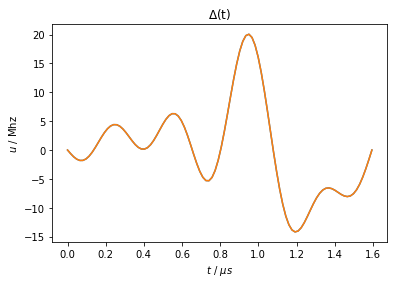

In [36]:
plt.plot(t_list,(u_delta@U)[0,:])
plt.plot(t_list,(u_delta@U)[1,:])
plt.xlabel('$t$ / $\mu s$')
plt.ylabel('$u$ / Mhz')
plt.title('$\Delta$(t)')

In [4]:
from CNOT import loss
from jax import hessian,jacrev
loss_p = lambda p:loss(t0,p,psi_i,psi_f)
Hess = jacrev(jacrev(loss_p))(res_state[1])
# print(Hess-Hess.transpose())

In [5]:
w,v = jnp.linalg.eig(Hess)
print(w.sort)
print(w.shape)

<bound method sort of DeviceArray([ 3.83062523e-01+0.j,  2.60651519e-01+0.j,
              1.33944539e-01+0.j,  3.36845180e-01+0.j,
              6.16026730e-02+0.j,  4.35965622e-02+0.j,
             -5.58830766e-04+0.j, -4.86713942e-04+0.j,
              4.72631745e-04+0.j,  2.34763671e-04+0.j,
              1.84722716e-04+0.j, -1.85812564e-04+0.j,
              1.37827522e-04+0.j,  1.00764481e-04+0.j,
             -1.39022868e-04+0.j, -1.03120967e-04+0.j,
              6.20688325e-05+0.j, -9.21602196e-05+0.j,
              3.14053481e-05+0.j,  2.28692456e-05+0.j,
              4.26637582e-05+0.j, -8.16460918e-05+0.j,
              3.14622465e-06+0.j, -2.47879293e-06+0.j,
             -1.40404057e-05+0.j, -1.22371099e-05+0.j,
             -4.19575375e-05+0.j, -2.80084549e-05+0.j,
             -3.46600097e-05+0.j, -3.28360821e-05+0.j,
             -3.54852445e-05+0.j], dtype=complex128)>
(31,)


In [6]:
arglist = jnp.argsort(w)[-5:]
main_eigen = w[arglist]
main_vec = v[:,arglist]

#SVD
print(main_vec.shape)
u,s,vd = jnp.linalg.svd(main_vec)
print(u.shape,s.shape,vd.shape)

(31, 5)
(31, 31) (5,) (5, 5)


In [10]:
print(s)

[1.00000001 1.         1.         1.         0.99999999]


Now we use this Hessian vector to do black box optimization

In [9]:
key1, key2 = random.split(key)
M = random.normal(key1,shape=(2**2,2**2)) + 1.j*random.normal(key2,shape=(2**2,2**2))
H_noise = M + jnp.conjugate(M.transpose())
# print(H_noise-H_noise.transpose().conj())
print(jnp.linalg.norm(H_noise))
print(H_noise)

6.312996386131131
[[-2.18655118+0.j         -0.5404706 -2.11401349j -0.87942616+1.63951292j
  -0.6226876 -0.11770122j]
 [-0.5404706 +2.11401349j  1.23264683+0.j          0.04009803+0.89911169j
   0.85206723+0.46883688j]
 [-0.87942616-1.63951292j  0.04009803-0.89911169j  2.49813897+0.j
  -1.09913255-1.10321593j]
 [-0.6226876 +0.11770122j  0.85206723-0.46883688j -1.09913255+1.10321593j
  -1.30479001+0.j        ]]


In [15]:
from jax import jit
from jax.experimental.ode import odeint

def noise_loss(flat_p,t1,psi_init,psi0,H_n):
    '''
    define the loss function with noise
    '''
    t_set = jnp.linspace(0., t1, 5)

    def func(y, t, *args):
        t1, flat_p, = args
        return -1.0j*(Hmat(t, flat_p, t1)+H_n)@y

    res = odeint(func, psi_init, t_set, t1, flat_p, rtol=1.4e-10, atol=1.4e-10)
    psi_final = res[-1, :]

    return (1 - jnp.abs(jnp.dot(jnp.conjugate(psi_final), psi0))**2)


def noise_loss_hessian(main_p,t1,vecmat,psi_init,psi0,H_n):
    '''
    define the loss function with noise, only optimize over smaller vector space
    '''
    t_set = jnp.linspace(0., t1, 5)
    flat_p = vecmat@main_p

    def func(y, t, *args):
        t1, flat_p, = args
        return -1.0j*(Hmat(t, flat_p, t1)+H_n)@y

    res = odeint(func, psi_init, t_set, t1, flat_p, rtol=1.4e-10, atol=1.4e-10)
    psi_final = res[-1, :]

    return (1 - jnp.abs(jnp.dot(jnp.conjugate(psi_final), psi0))**2)

In [ ]:
from scipy.optimize import minimize

loss1 = lambda p: noise_loss(p,t0,psi_i,psi_f,H_noise)
loss2 = lambda p: noise_loss_hessian(p,t0,main_vec,psi_i,psi_f,H_n)

initial_guess = res_state[1]

opt_res = minimize(loss1, initial_guess, method='Nelder-Mead')

In [2]:
from Xgate import GateOptimize
N = 1 # single qubit
N1 = 10 # parameter space size

sz = jnp.array([[1,0],[0,-1]],dtype=jnp.float32)

sx= jnp.array([[0,1],[1,0]],dtype=jnp.float32)

omega0 = 1.
p = random.normal(key,shape=(N1,)) #p initial
t0 = 1.
gate_loss, p_final = GateOptimize(sx,omega0, t0, p, num_step=300, learning_rate=1.2)

final loss =  0.0004750443587894657946571


Now that we have the ideal result under master frequency $\omega$. With a change of frequency $\delta \omega$, the hyperparameter will change accordingly $\delta \vec{p}$

The method is to use Hessian matrix to get a minimal hyperparameter set